In [26]:
import torch
from PIL import Image
import os

from torch import nn
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

In [22]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.all_images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.all_images[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            tensor_image = self.transform(image)
        else:
            raise ValueError("transform参数不能为None，需指定预处理方法")
        noise_factor = 0.5
        nosie_images = tensor_image + torch.randn_like(tensor_image) * noise_factor
        nosie_images = torch.clamp(nosie_images, 0., 1.)
        return nosie_images, tensor_image

In [24]:
# 创建数据集
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
transform = transforms.Compose([transforms.Resize((68, 68)), transforms.ToTensor()])
dataset = ImageDataset("/Users/zhangyf/PycharmProjects/image_process/common/dataset", transform)
print(len(dataset))

24853


In [25]:
# 划分训练集和测试集
train_dataset, test_dataset = random_split(dataset, [0.75, 0.25])
print(len(train_dataset))
print(len(test_dataset))

18640
6213


In [28]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
for x, y in train_loader:
    print(x.shape, x.device)
    print(y.shape, y.device)
    break

torch.Size([32, 3, 68, 68]) cpu
torch.Size([32, 3, 68, 68]) cpu


In [35]:
# 搭建模型
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        # 编码器
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
        # 通用池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 解码器
        self.t_conv1 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=2, stride=2)
        # 普通卷积层
        self.conv_out = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        # print(f'conv1:{x.shape}')
        x = self.pool(x)
        # print(f'pool1:{x.shape}')
        x = torch.relu(self.conv2(x))
        # print(f'conv2:{x.shape}')
        x = self.pool(x)
        # print(f'pool2:{x.shape}')
        x = torch.relu(self.conv3(x))
        # print(f'conv3:{x.shape}')
        x = self.pool(x)
        # print(f'pool3:{x.shape}')
        x = torch.relu(self.t_conv1(x))
        # print(f't_conv1:{x.shape}')
        x = torch.relu(self.t_conv2(x))
        # print(f't_conv2:{x.shape}')
        x = torch.relu(self.t_conv3(x))
        # print(f't_conv3:{x.shape}')
        x = torch.sigmoid(self.conv_out(x))
        # print(f'conv_out:{x.shape}')
        return x

In [38]:
# 前向传播测试
model = ConvDenoiser().to(device)
# y = model(torch.randn(1,3,68,68).to(device))
print(model)
# print(y.shape,y.device)

ConvDenoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [39]:
# 定义损失函数和优化器
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [42]:
# 训练
epochs = 10
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(train_loader)
    print("epoch:{}, loss:{}".format(epoch, avg_loss))
torch.save(model.state_dict(),"denoiser_model.pth")

epoch:1, loss:0.009270579227697603
epoch:2, loss:0.009209432607177402
epoch:3, loss:0.00918138946192115
epoch:4, loss:0.009135073314891341
epoch:5, loss:0.009083125786695796
epoch:6, loss:0.00904757089279208
epoch:7, loss:0.00901025534956316
epoch:8, loss:0.008961153124647913
epoch:9, loss:0.008947992828575401
epoch:10, loss:0.008870420487008708


In [55]:
# 验证模型效果
# 从测试数据加载器获取一个批次图像数据
loder_iter = iter(test_loader)
noise_imgs,original_imgs = next(loder_iter)
print(noise_imgs.shape)
print(original_imgs.shape)

torch.Size([32, 3, 68, 68])
torch.Size([32, 3, 68, 68])


In [56]:
model = model.to(device)
noise_imgs = noise_imgs.to(device)
original_imgs = original_imgs.to(device)
output = model(noise_imgs)
print(output.shape)

torch.Size([32, 3, 68, 68])


In [57]:
noise_imgs = noise_imgs.permute(0, 2, 3, 1).cpu().numpy()
original_imgs = original_imgs.permute(0, 2, 3, 1).cpu().numpy()
output = output.permute(0, 2, 3, 1).detach().cpu().numpy()
print(output.shape)

(32, 68, 68, 3)


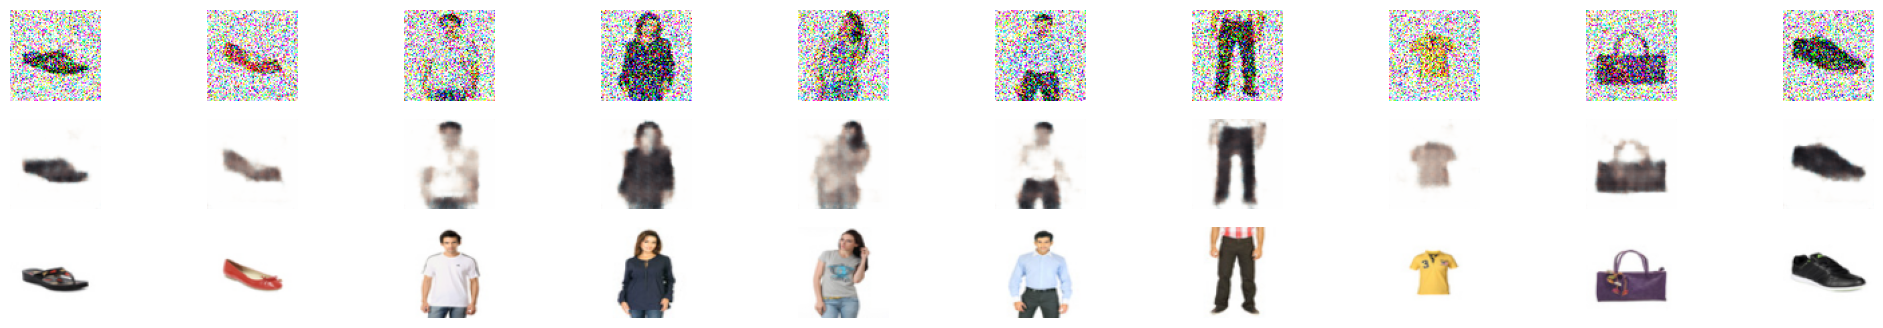

In [66]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(3,10,figsize=(25,4))
for imgs,row in zip([noise_imgs,output,original_imgs],axes):
    for img,ax in zip(imgs,row):
        ax.imshow(img)
        ax.axis('off')
plt.show()

In [67]:
import re

In [74]:
a = re.split(r'([0-9]+)',"img1000ddd")
b = re.split(r'([0-9]+)',"img2ddd")
print(a)
print(b)
print(a < b)

['img', '1000', 'ddd']
['img', '2', 'ddd']
True


In [73]:
convert = lambda text: int(text) if text.isdigit() else text.lower()
key1 = [convert(c) for c in a]
key2 = [convert(c) for c in b]
print(key1 < key2)

False
